In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('diabetes_data.csv')
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Limpiar Datos
# Obtener las columnas no numéricas con valores únicos
columnas_no_numericas = df.select_dtypes(exclude=[np.number]).columns
diccionario_mapeo = {}

# Mapear las columnas no numéricas con valores únicos a enteros
for columna in columnas_no_numericas:
    valores_unicos = df[columna].unique()
    diccionario_mapeo[columna] = {valor: indice for indice, valor in enumerate(valores_unicos)}
    df[columna] = df[columna].map(diccionario_mapeo[columna])

# Imputar los valores faltantes con la media de cada columna numérica
columnas_numericas = df.select_dtypes(include=[np.number]).columns
df[columnas_numericas] = df[columnas_numericas].fillna(df[columnas_numericas].mean())

In [10]:
df.columns

Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')

In [11]:
# Separamos la ultima columna para que sea variable destino
datos_y = df['Smoker']
datos_y.head()

0    0.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: Smoker, dtype: float64

In [12]:
# Eliminamos las columnas que no funcionarán
datos_x = df.drop(columns=['Smoker'])
datos_x.head()

,Age,Sex,HighChol,CholCheck,BMI,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Dividir datos entre entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.2, random_state=2)
print(
    "X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
n_entradas = X_train.shape[1]
#registro/columnas

X Train: (56553, 17), X Test: (14139, 17), y_train: (56553,), y_test: (14139,)


In [14]:
#Ahora vamos a escalar los valores para que esten dentro de un rango mas corto.
# Escalar los valores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#Para poder procesar los datos en la red neuronal necesitamos que todos los datos estén en tensores, asi que haremos las conversiones necesarias
# Convertir los datos a tensores
t_X_train = torch.from_numpy(X_train).float().to("cpu")
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).long().to("cpu")  # Cambiamos a long para clasificación
t_y_test = torch.from_numpy(y_test.values).long().to("cpu")  # Cambiamos a long para clasificación

In [18]:
#Ahora vamos a crear el modelo de la red neuronal
class Modelo(nn.Module):
    def __init__(self, n_entradas):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 10)
        self.linear3 = nn.Linear(10, 2)  # Cambiamos la salida a 2 para clasificación binaria

    def forward(self, inputs):
        pred_1 = torch.relu(self.linear1(inputs))
        pred_2 = torch.relu(self.linear2(pred_1))
        pred_final = F.softmax(self.linear3(pred_2), dim=1)  # Usamos softmax para clasificación
        return pred_final

In [24]:
# Entrenamiento
learning_rate = 0.01
epoca = 1000
estatus_print = 100
model = Modelo(n_entradas=n_entradas)
loss_fn = nn.CrossEntropyLoss()  # Cambiamos la función de pérdida para clasificación
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Modelo: {}".format(model))
historico = pd.DataFrame()
print("Modelo entrenado...")
for epoch in range(1, epoca + 1):
    y_pred = model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoca} \t Loss: {round(loss.item(), 4)}")
    with torch.no_grad():
        y_pred = model(t_X_test)
        _, predicted_labels = torch.max(y_pred, 1)  # Obtener las etiquetas predichas con mayor probabilidad
        correct = (predicted_labels == t_y_test).sum().item()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy))
    df_tmp = pd.DataFrame(data={
        'Epoca': epoch,
        'Perdida': round(loss.item(), 4),
        'Presición': round(accuracy, 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)
print("Accuracy final: {}".format(round(accuracy, 4)))

Modelo: Modelo(
  (linear1): Linear(in_features=17, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)
Modelo entrenado...
Accuracy: 53.27816677275621
Accuracy: 57.92488860598345
Accuracy: 58.448263667869014
Accuracy: 58.497772119669
Accuracy: 58.61800693118325
Accuracy: 58.844331282268904
Accuracy: 59.20503571681166
Accuracy: 59.622321239125824
Accuracy: 59.82742768229719
Accuracy: 60.10326048518283
Accuracy: 60.32251220029705
Accuracy: 60.34373010821133
Accuracy: 60.520546007496996
Accuracy: 60.520546007496996
Accuracy: 60.555909187354125
Accuracy: 60.63370818303982
Accuracy: 60.72565245066836
Accuracy: 60.82466935426834
Accuracy: 61.01563052549685
Accuracy: 61.08635688521112
Accuracy: 60.93783152981116
Accuracy: 61.22073696866822
Accuracy: 61.24902751255393
Accuracy: 61.31268123629677
Accuracy: 61.27731805643963
Accuracy: 61.32682650823962
Accuracy: 61.36926232406818
Accuracy: 6

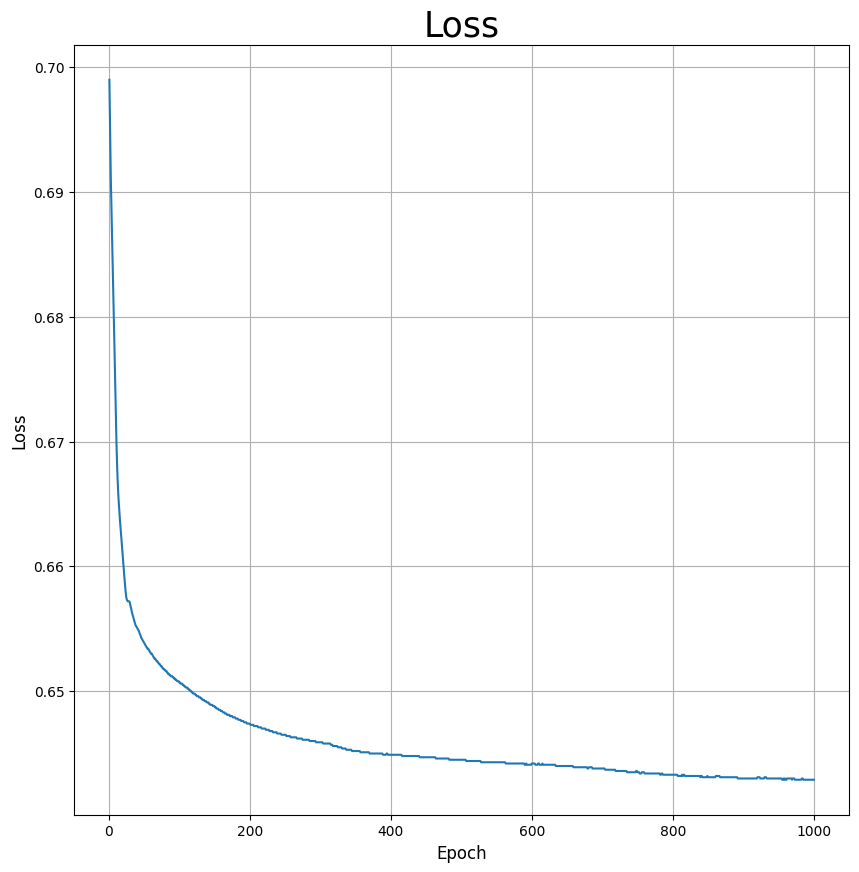

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoca'], historico['Perdida'], label='Perdida')
plt.title("Perdida", fontsize=25)
plt.xlabel("Epoca", fontsize=12)
plt.ylabel("Perdida", fontsize=12)
plt.grid()
plt.show()

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoca'], historico['Presicion'], label='Presicion')
plt.title("Presicion", fontsize=25)
plt.xlabel("Epoca", fontsize=12)
plt.ylabel("Presicion", fontsize=12)
plt.grid()
plt.show()

KeyError: 'Epoca'

<Figure size 1000x1000 with 0 Axes>